Hyperparameter Tuning:

Optimizer                      
Learning Rates  
Batch Sizes  
Epochs  
Number of neurons   
Number of layers  

Loss Func: MSE (MAPE not recommended)

Performance: R square, RMSE, MAPE

LSTM with multistep prediction (No EMA_40)

Next step:  
Add Variance/Volatility  
Test using different prediction step (13,26,52)  
Consider using only certain timestep for prediction (eg. 5 years, 3 years, 1 years)  
Hyperparameter Tune

In [1]:
# !pip install stock-indicators

import pandas as pd
# from stock_indicators import indicators
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, TimeDistributed, Masking, Lambda
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

mixed_precision.set_global_policy(mixed_precision.Policy('mixed_float16'))

from sklearn.model_selection import TimeSeriesSplit, train_test_split

In [2]:
# Dataset Preprocessing

# Weekly data
data = pd.read_excel('S&P 500.xlsx')

# Data Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

scaler1 = MinMaxScaler(feature_range=(0, 1))
scaled_data1 = scaler1.fit_transform(data['EMA_40'].values.reshape(-1,1))

# Collect regime data
with open('Regime.txt', 'r') as f:
    r = f.readlines()

regime = [int(x) for x in list(r[0])]
regime = np.array(regime).reshape(-1,1)
# Remove first 2 data due to the loss in data in MSAR
x = scaled_data[2:,]
x1 = scaled_data1[2:,]

print(x.shape, regime.shape, x1.shape)

# Create dataset from t=0 to t=t
def create_data(data, regime, data1, initial=100, interval=10, predict_step=10, max=2000):
    n = (len(data)-initial-predict_step) // interval
    x = []
    r = []
    x1 = []
    y = []

    # To monitor datasize timeframe
    # timeframe = []
    for i in range(n):
        x.append(data[:(initial+i*interval)])
        r.append(regime[:(initial+i*interval)])
        x1.append(data1[:(initial+i*interval)])
        y.append(data[(initial+i*interval):(initial+i*interval+predict_step), 0:1])
        
        # timeframe.append(initial+i*interval)

    # print(timeframe)

    # Padding
    x = pad_sequences(x, maxlen=max, padding='pre', value=-1, dtype='float32')
    r = pad_sequences(r, maxlen=max, padding='pre', value=-1, dtype='float32')
    x1 = pad_sequences(x1, maxlen=max, padding='pre', value=-1, dtype='float32')
    
    return np.array(x), np.array(r), np.array(x1), np.array(y)

x, r, x1, y  = create_data(x, regime, x1, 100, 10, 26, 1100)
print(x.shape, r.shape, x1.shape, y.shape)

(1041, 1) (1041, 1) (1041, 1)
(91, 1100, 1) (91, 1100, 1) (91, 1100, 1) (91, 26, 1)


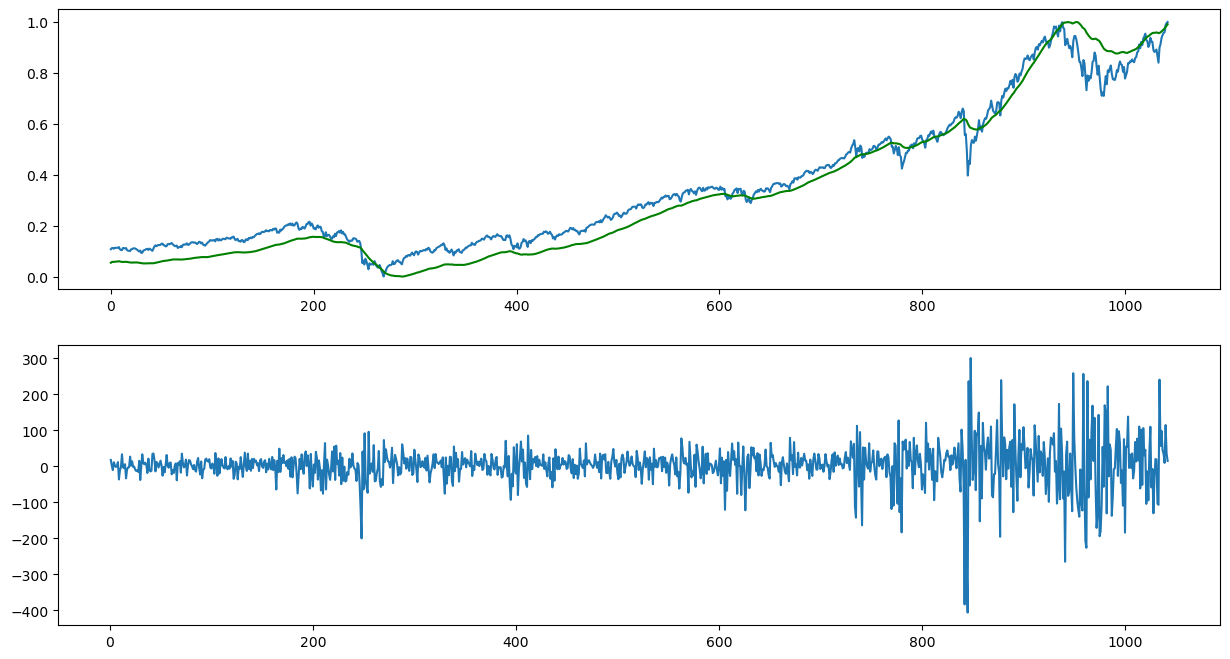

In [3]:
# EDA
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,8))
axs[0].plot(scaled_data)
axs[0].plot(range(data.shape[0]), scaled_data1, color='green')

axs[1].plot(data['Close'].diff())


In [4]:
def LSTM_Model(data, regime, test):
    input1 = Input(shape=data)
    input2 = Input(shape=regime)
    input3 = Input(shape=test)

    input_concat = Concatenate()([input1, input2])
    
    # Cannot concat after masking
    x = Masking(mask_value=-1.0)(input_concat)

    x = LSTM(units=150, activation='tanh', return_sequences=False)(x)
    # Semi-quarterly prediction 
    output = Dense(26)(x)

    model = Model(inputs=[input1, input2], outputs=output)
    
    #beta_1, beta_2, clipnorm, weight_decay yet to be tested
    opt = tf.keras.optimizers.Adam(learning_rate=0.005, weight_decay=0.0001)
    
    # Must use MSE, not MAPE: Diff in calc loss func and hence BPN
    model.compile(optimizer=opt, loss='mse')

    return model


# Build the model
# Rerun if need to reset model
print((x.shape[1], x.shape[2]), (r.shape[1], r.shape[2]), (x1.shape[1], x1.shape[2]))

model = LSTM_Model((x.shape[1], x.shape[2],), (r.shape[1], r.shape[2],), (x1.shape[1], x1.shape[2],))
model.summary()

(1100, 1) (1100, 1) (1100, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1100, 1)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 1100, 1)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 1100, 2)           │               0 │ input_layer[0][0],         │
│                               │                           │                 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 1100, 2)           │               0 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking (Masking)             │ (None, 1100, 2)           │               0 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any (Any)                     │ (None, 1100)              │               0 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 150)               │          91,800 │ masking[0][0], any[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 26)                │           3,926 │ lstm[0][0]                 │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 95,726 (373.93 KB)

 Trainable params: 95,726 (373.93 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Sliding Window Time Series Split
def Train_Test(data, regime, data1, y, split=3):
    
    x = np.array_split(data, split)
    r = np.array_split(regime, split)
    x1 = np.array_split(data1, split)
    re = np.array_split(y.astype('float32'), split)

    ES = EarlyStopping(monitor='val_loss', patience=20, start_from_epoch=20, restore_best_weights=True, verbose=1)

    for i in range(split):
        print(i, x[i].shape, r[i].shape, x1[i].shape, re[i].shape)
        
        x_train, x_test, y_train, y_test =  train_test_split(x[i], re[i], test_size=0.1, shuffle=False)
        r_train, r_test, _, _ =  train_test_split(r[i], re[i], test_size=0.1, shuffle=False)
        x1_train, x1_test, _, _ =  train_test_split(x1[i], re[i], test_size=0.1, shuffle=False)

        print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


        model.fit([x_train, r_train], y_train, epochs=100, validation_data=([x_test, r_test], y_test), callbacks=[ES], batch_size=4)

    return

Train_Test(x, r, x1, y, 3)

0 (31, 1100, 1) (31, 1100, 1) (31, 1100, 1) (31, 26, 1)
(24, 1100, 1) (7, 1100, 1) (24, 26, 1) (7, 26, 1)
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.0120 - val_loss: 0.0019
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0022 - val_loss: 0.0032
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 997ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0014 - val_loss: 8.3021e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0014 - val_loss: 7.8881e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0010 - val_loss: 7.2357e-04
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0013 - val_loss: 6.8005e-04
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.0017 - val_loss: 0.0017
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - lo

(1, 1041, 1) (1, 1041, 1) (1, 1041, 1)
(1, 1041, 1) (1, 1041, 1) (1, 1041, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
[[1.045 1.024 1.026 1.025 1.035 1.04  1.046 1.062 1.067 1.069 1.061 1.053
  1.039 1.028 1.019 1.022 1.021 1.053 1.062 1.056 1.039 1.041 1.033 1.027
  1.014 1.027]]
[[4952. 4868. 4876. 4872. 4912. 4932. 4956. 5020. 5044. 5052. 5016. 4984.
  4928. 4884. 4844. 4860. 4856. 4984. 5020. 4996. 4928. 4936. 4904. 4880.
  4824. 4880.]]
2023-12-18T00:00:00.000000000


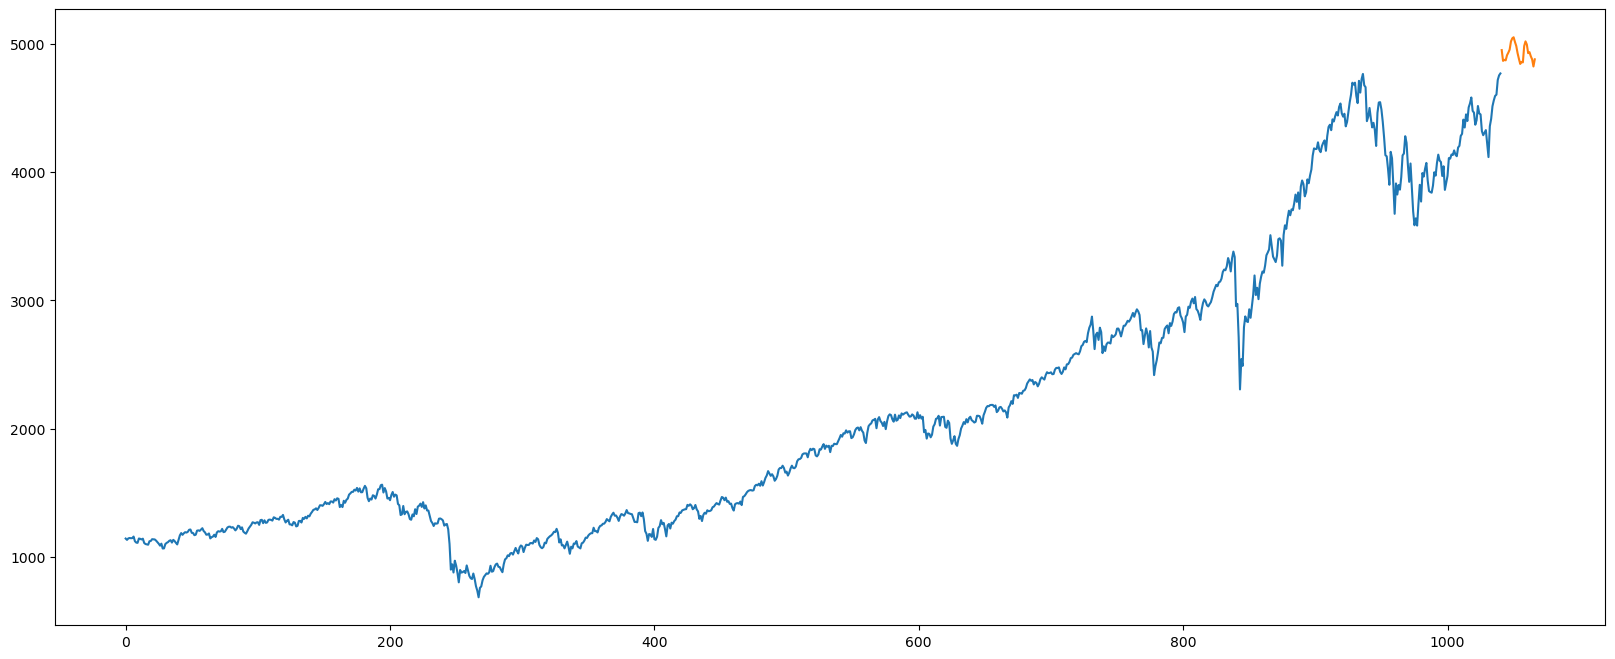

In [28]:
def Test(t, data, regime, data1):
    
    d = scaler.transform(data.reshape(-1, 1))
    d1 = scaler1.transform(data1.reshape(-1, 1))

    d = d[2:].reshape(1,-1,1)
    d1 = d1[2:].reshape(1,-1,1)
    r = np.array(regime).reshape(1,-1,1)

    print(d.shape, d1.shape, r.shape)
    print(d[:,:t].shape, d1[:,:t].shape, r[:,:t].shape)

    a = pad_sequences(d[:,:t], maxlen=1100, padding='pre', value=-1, dtype='float32')
    b = pad_sequences(r[:,:t], maxlen=1100, padding='pre', value=-1, dtype='float32')
    c = pad_sequences(d1[:,:t], maxlen=1100, padding='pre', value=-1, dtype='float32')

    p = model.predict([a,b])
    # plt.subplots(figsize=(20,5))
    # plt.plot(a.reshape(-1,1))
    # plt.plot(range(a.shape[1],a.shape[1]+10), p.reshape(-1,1), color='red')
    # plt.show()
    print(p)
    p = scaler.inverse_transform(p.reshape(-1,1))
    # To let data output horizontally
    print(p.reshape(1,-1))

    plt.subplots(figsize=(20,8))
    plt.plot(data[2:])
    plt.plot(range(t,26+t), p)

    return

Test(1041, data['Close'].values, regime, data['EMA_40'].values)
print(data['Date'].values[1041])

In [3]:
def Save_Model(model, name):
    model.save(f'{str(name)}.keras')
    return

def Load_Model(name):
    m = tf.keras.models.load_model(f'{str(name)}.keras')
    return m

# Save_Model(model, 'LSTM v4.1')

In [4]:
model = Load_Model('LSTM v4.1')

In [ ]:
# TimeSeriesSplit (Multiple input of previous training data, inefficient)
# def Train_Test(data, regime, data1, result, split=2):

#     tss = TimeSeriesSplit(n_splits=split)

#     ES = EarlyStopping(monitor='val_loss', patience=20, start_from_epoch=20, restore_best_weights=True, verbose=1)

#     for train_idx, test_idx in tss.split(data):
#         x, r, x1, y = data[train_idx], regime[train_idx], data1[train_idx], result[train_idx]
#         xt, rt, x1t, yt = data[test_idx], regime[test_idx], data1[test_idx], result[test_idx]
                
#         print(x.shape, r.shape, x1.shape, y.shape)
#         print(xt.shape, rt.shape, x1t.shape, yt.shape)

#         model.fit([x, r, x1], y, epochs=3, validation_data=([xt, rt, x1t], yt), callbacks=[ES], batch_size=4)

#     return

# Train_Test(x, r, x1, y)